# Activate IAF Neuron

## 0. Kick the Baby
If you've ever watched *South Park*, then you probably remember one scene in which Kyle punts his little brother Ike like a football after saying,
>"Kick the baby!"

,to which Ike responds,

>Don't kick the goddamn baby!

![Kick the Baby!](../Figures/KickBaby.jpg)

In this lab, we're also gonna *Kick the Baby*!

>More specifically, *Baby* stands for the **integrate-and-firing(IAF) neuron** and *Kick* stands for **activating with spikes**.

In [1]:
# %matplotlib inline

# System Env
import sys
sys.path.append('..')

# Nest Modules
import nest
import nest.topology as tp

# Help Functions
from CNT.visualize import visualSS, visualVS, visualWM
from CNT.spikeAnalyzer import spike2bin, spikeCoin

# Common Modules
import numpy as np
import matplotlib.pyplot as plt

# Calculation Functions
from scipy.special import erf
from scipy.optimize import fmin

# Auto Reloading
%load_ext autoreload
%autoreload 2

## 1. IAF Neuron

$$C_m\frac{dV_m(t)}{dt} = I(t) - g_L(V_m-E_L)$$

The equation above is the capcitor-resistor model of an IAF neuron. It simply **integrates** ions and **fires** when reaching a boundary.

Our first try would be activating an IAF neuron with constant **current injection** $I(t)=I_0$. 
>Now, let's give it a KICK!

<Figure size 432x288 with 0 Axes>

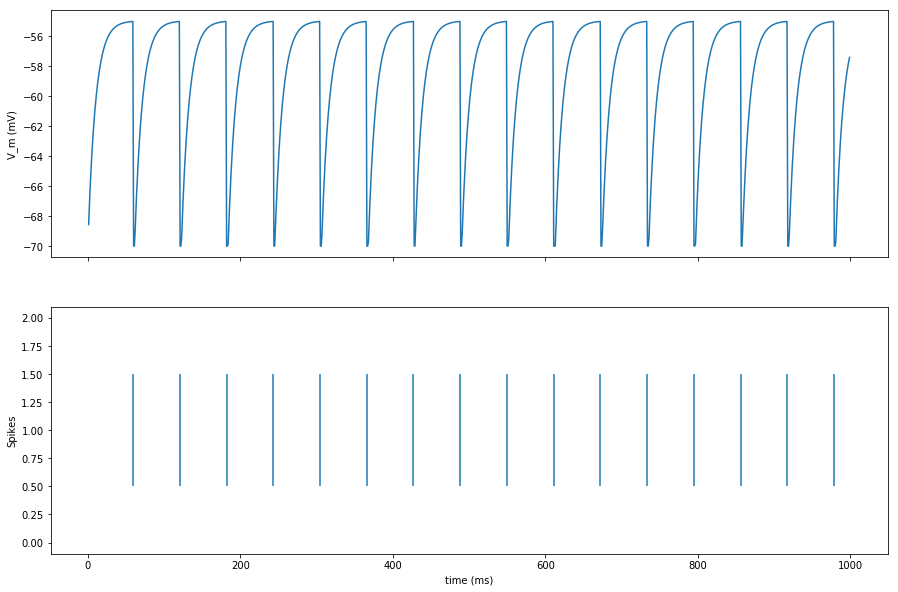

In [2]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Initialize nest env
nest.ResetKernel()
nest.SetKernelStatus({"resolution": dt})

# Create a naive iaf neuron
neuron = nest.Create('iaf_psc_alpha')

# Set constant current injection
nest.SetStatus(neuron, "I_e", 376.0)

# Create a voltmeter device
vm = nest.Create('voltmeter')
nest.SetStatus(vm, "withtime", True)

# Create a spike detector device
sd = nest.Create('spike_detector')

# Connect devices to neuron
nest.Connect(vm, neuron)
nest.Connect(neuron, sd)

# Simulate
nest.Simulate(T)

# Visualize soma recording(voltmeter) and spiking activities(spike detector)
visualVS(vm, sd);

So the neuron spikes and resets periodically with constant current injection. Well, not so interesting as we already know it. 
>Let's try something else, something that ... **makes more sense**?

One thing that you should keep in mind is that when neuroscientists talk about making sense, they probably have the idea of **biological plausibility** in mind. Let's just stick to this meaning as start and take a glimpse of what could happen in real brain.

## 2. E-I input

We already know that the number of synapses(input connections) a single neuron has is at the scale of *hundred* or *thousand*. Some of those synapses are **excitatory** connections and some are **inhibitory** connections. Now comes the question:

> Why do we need two types of inputs?

Let's just go ahead and connect our IAF neuron with one **excitatory** synapse and one **inhibitory** synapse. The model of IAF is now:

$$C_m\frac{dV_m(t)}{dt} = I(t) - g_L(V_m-E_L) + I_{exc}^{syn} + I_{inh}^{syn}$$

And this time we use **poisson spike trains**(spikes) to kick the neuron. A **poisson spike train** simply means a random sequence of spikes -- at each timestep, we flip a coin to decide whether there is a spike.

> No more blah, let's just KICK IT!

<Figure size 432x288 with 0 Axes>

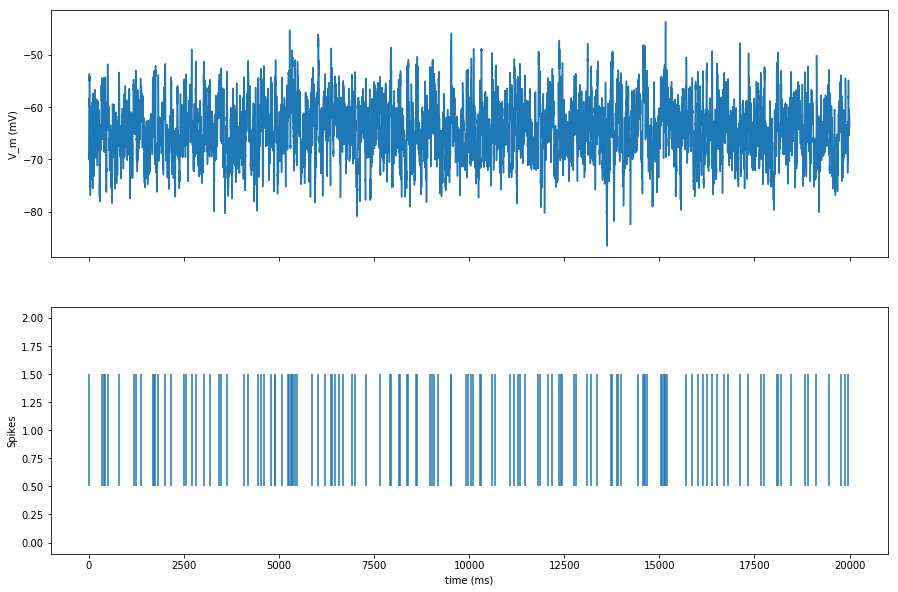

In [3]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 20000   # Total duration

# Initialize nest env
nest.ResetKernel()
nest.set_verbosity('M_WARNING')

# Input source
weights = [0.5,-0.33]    # (mV) psp amplitudes (positive for excitatory, negative for inhibitory)
rates = [10000.,10000.]  # (1/s) rate of Poisson sources

# Soma
C_m = 250.0       # (pF) capacitance
E_L = -70.0       # (mV) resting potential
I_e = 0.0         # (nA) external current
V_reset = -70.0   # (mV) reset potential
V_th = -55.0      # (mV) firing threshold
t_ref = 2.0       # (ms) refractory period
tau_m = 10.0      # (ms) membrane time constant

# Synapse
tau_syn_ex = .5   # (ms) excitatory synaptic time constant
tau_syn_in = 2.0  # (ms) inhibitory synaptic time constant

# Summary
neurondict = {'V_th': V_th, 'tau_m': tau_m, 'tau_syn_ex': tau_syn_ex,
              'tau_syn_in': tau_syn_in, 'C_m': C_m, 'E_L': E_L, 't_ref': t_ref,
              'V_m': E_L, 'V_reset': E_L}

# Units
pF = 1e-12
ms = 1e-3
pA = 1e-12
mV = 1e-3

# Theoretical calculation
mu = 0.0
sigma2 = 0.0
J = []

assert(len(weights) == len(rates))

# Campbell's theorem
for rate, weight in zip(rates, weights):
    # synapse type
    if weight > 0:
        tau_syn = tau_syn_ex
    else:
        tau_syn = tau_syn_in

    # post synaptic respond
    t_psp = np.arange(0., 10. * (tau_m * ms + tau_syn * ms), 0.0001) # delay
    
    def psp(x): # amplitude
        return - ((C_m * pF) / (tau_syn * ms) * (1 / (C_m * pF)) *
                  (np.exp(1) / (tau_syn * ms)) *
                  (((-x * np.exp(-x / (tau_syn * ms))) /
                    (1 / (tau_syn * ms) - 1 / (tau_m * ms))) +
                   (np.exp(-x / (tau_m * ms)) - np.exp(-x / (tau_syn * ms))) /
                   ((1 / (tau_syn * ms) - 1 / (tau_m * ms)) ** 2)))

    # synaptic strength
    min_result = fmin(psp, [0], full_output=1, disp=0)
    
    fudge = -1. / min_result[1]
    J.append(C_m * weight / (tau_syn) * fudge)
    
    # mean
    mu += (rate * (J[-1] * pA) * (tau_syn * ms) *
           np.exp(1) * (tau_m * ms) / (C_m * pF))

    # square variance
    sigma2 += rate * (2 * tau_m * ms + tau_syn * ms) * \
        (J[-1] * pA * tau_syn * ms * np.exp(1) * tau_m * ms /
         (2 * (C_m * pF) * (tau_m * ms + tau_syn * ms))) ** 2

# Mean and variance
mu += (E_L * mV)
sigma = np.sqrt(sigma2)

# Set IAF neuron
nest.SetDefaults('iaf_psc_alpha', neurondict)
n_spike = nest.Create('iaf_psc_alpha')
n_free = nest.Create('iaf_psc_alpha', 1, [{'V_th': 1e12}])

# Poisson input
pg = nest.Create('poisson_generator', len(rates),
                 [{'rate': float(rate_i)} for rate_i in rates])
n_parrot = nest.Create('parrot_neuron',len(rates))
nest.Connect(pg, n_parrot, 'one_to_one')

# Create a voltmeter device
vm = nest.Create('voltmeter', 1, [{'interval': .1}])

# Create a spike detector device
sd = nest.Create('spike_detector')

# Connect input
for i, currentpg in enumerate(n_parrot):
    nest.Connect([currentpg], n_spike,
                 syn_spec={'weight': J[i], 'delay': 0.1})
    nest.Connect([currentpg], n_free,
                 syn_spec={'weight': J[i]})

# Connect devices
nest.Connect(vm, n_free)
nest.Connect(n_spike, sd)

# Simulate
nest.Simulate(T)

# Visualize soma recording(voltmeter) and spiking activities(spike detector)
visualVS(vm, sd);

* The upper plot shows the membrane potential of a free neuron(firing threshold set to *infinity*,1e12 here). It shows the **temporal integration** of inputs.
* The lower plot shows how a normal neuron(firing threshold set to -55mV) **spikes** with the same inputs.

> For the free neuron, we *approximate* the **mean** and **vairance** of the membrane potential with **Campbell's theorem**!

In [4]:
# Experimental result amd theoretical calculation
v_free = nest.GetStatus(vm, 'events')[0]['V_m'][500:-1]
print('mean membrane potential (actual / calculated): {0} / {1}'
      .format(np.mean(v_free), mu * 1000))
print('variance (actual / calculated): {0} / {1}'
      .format(np.var(v_free), sigma2 * 1e6))

mean membrane potential (actual / calculated): -64.41232060482967 / -64.29458061397663
variance (actual / calculated): 28.20579564193807 / 28.881442541552477


Now comes the questions:

> **What happens when both the strength of excitatory and inhibitory synapses are increased? Can you maintain a similar mean membrane potential but rather different variance? What's the implication?**

## 3. Pair-wise Correlation Via Connection

> Let's add some spice to the game by considering a **pair** of IAF neurons!

For a pair of neurons, a natural property is pair-wise correlation. Here, natural property means it arises naturally when connecting neurons into a **network** and correlation denotes the **coincindence** of spikes between two neurons' activities.

### A Two-layer Network

> Behold, a two-layer network of IAF neurons!

In [5]:
# Initialize nest env
nest.ResetKernel()

N_noise = 20  # size of Poisson group(input pool)
rate_noise = 100.0  # firing rate of Poisson neurons (Hz)
p_noise = 0.9  # connection probability from noise to population
r_noise = 0.4  # neighbourhood size
w_noise = 200.0  # synaptic weights from Poisson to population neurons (pA)
d_noise = 10.0  # synaptic weights fluctuation

N_ex = 50  # size of the population
p_ex = 0.6  # connection probability inside the population
r_ex = 0.5  # neighbourhood size
w_ex = 30.0  # synaptic weights inside the population (pA)
d_ex = 10.0  # synaptic weights fluctuation

# Topoloy
radius = 0.5
# Neuron(output) population
pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for i in range(N_ex)]
# pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for i in range(N_ex)]
output_dict = {"positions": pos,
            "elements" : "iaf_psc_alpha"}
output_layer = tp.CreateLayer(output_dict)

# Noise(input) population
pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for j in range(N_noise)]
nest.CopyModel("poisson_generator", 'poisson_input', params={'rate': rate_noise})
input_dict = { "positions": pos,
                "elements" : 'poisson_input'} # the element at each (x,y) coordinate in the grid
input_layer = tp.CreateLayer(input_dict)

# Recurrent connection
recondict = {'connection_type': 'divergent', 
             'mask': {'spherical': {'radius': r_ex}},
             'kernel': p_ex,
             'weights': {'uniform': {'min': w_ex-d_ex, 'max': w_ex+d_ex}},
             'allow_autapses': False}
tp.ConnectLayers(output_layer, output_layer, recondict)

# Divergent connection
incondict = {'connection_type': 'divergent', 
             'mask': {'spherical': {'radius': r_noise}}, 
             'kernel': p_noise,
             'weights': {'uniform': {'min': w_noise-d_noise, 'max': w_noise+d_noise}},
             'allow_multapses': False,
             'allow_autapses': False}
tp.ConnectLayers(input_layer, output_layer, incondict)

# Detectors
spike_det = nest.Create("spike_detector")
out_det = nest.Create('spike_detector', N_ex)
in_det = nest.Create('spike_detector', N_noise)

# Connect detectors
nest.Connect(nest.GetNodes(output_layer)[0], spike_det)
nest.Connect(nest.GetNodes(output_layer)[0], out_det, 'one_to_one')
nest.Connect(nest.GetNodes(input_layer)[0], in_det, 'one_to_one')

/Users/michaelh/.nest/lib/python3.7/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetNodes is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


Let's take a look at the topology of this network. There are two ensembles of neurons randomly distributed in 3D space. We'll call those two ensembles the *input layer* (20 neurons) and the *output layer* (100 neurons). Neurons in the input layer, input neurons; neurons in the output layer, output neurons.

#### Input Layer

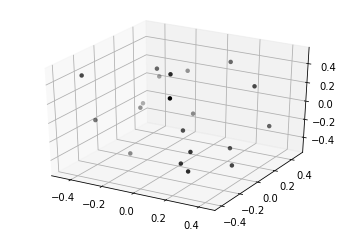

In [6]:
tp.PlotLayer(input_layer, nodesize=20, nodecolor='k');

#### Output Layer

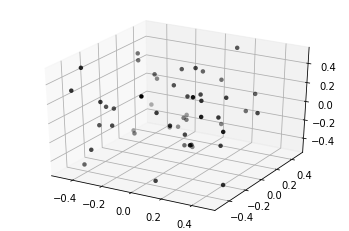

In [7]:
tp.PlotLayer(output_layer, nodesize=20, nodecolor='k');

#### Divergent Connection

Input neurons generate **poisson spike trains** which kick the output neurons. Input neurons connect to output neurons in a divergent way. As shown below, an input neuron in the center, red dot, connects to several output neurons, green dots, in the overlapped space(overlap the space of input layer and output layer).

/Users/michaelh/.nest/lib/python3.7/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetChilden is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


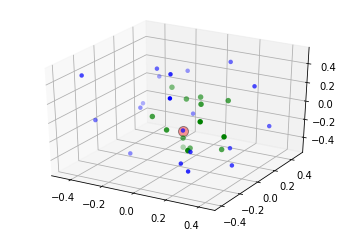

In [8]:
# Visualize
layer = input_layer
condict = incondict

# layer nodes
fig = tp.PlotLayer(layer, nodesize=20)

# kernel
ctr = tp.FindCenterElement(layer)
tp.PlotTargets(ctr, output_layer, fig=fig,
               mask=condict['mask'],
               kernel=condict['kernel'], kernel_color='green',
               src_size=100, tgt_color='green', tgt_size=30);

The connections can be visualized with **connection matrix** as below.

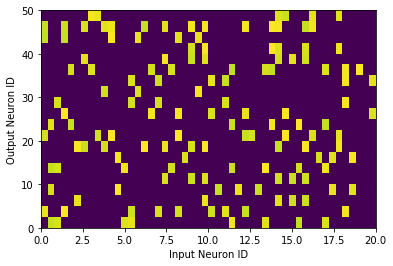

In [9]:
visualWM(nest.GetNodes(input_layer)[0],nest.GetNodes(output_layer)[0]);

#### Recurent Connection

Neurons in the output layer are **inter-connected IAF neurons** receiving stimulus from the input layer. Each output neuron is connected to its neighbours with certain probability(recurrent connection). As shown below, an output neuron, red dot, connects to several neighbouring neurons, green dots.

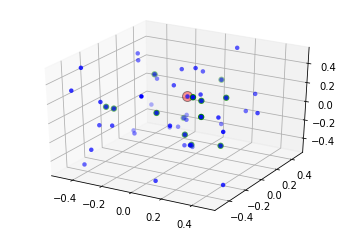

In [10]:
# Visualize
layer = output_layer
condict = recondict

# layer nodes
fig = tp.PlotLayer(layer, nodesize=20)

# kernel
ctr = tp.FindCenterElement(layer)
tp.PlotTargets(ctr, layer, fig=fig,
               mask=condict['mask'],
               kernel=condict['kernel'], kernel_color='green',
               src_size=100, tgt_color='green', tgt_size=40);

Similarly, we can visualize it with **connection matrix** as below.

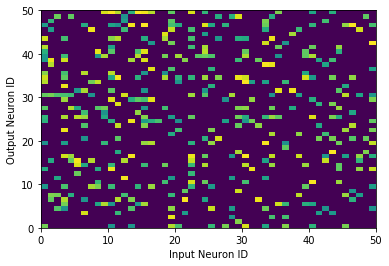

In [11]:
visualWM(nest.GetNodes(output_layer)[0],nest.GetNodes(output_layer)[0]);

>Cool, let's KICK IT!

<Figure size 432x288 with 0 Axes>

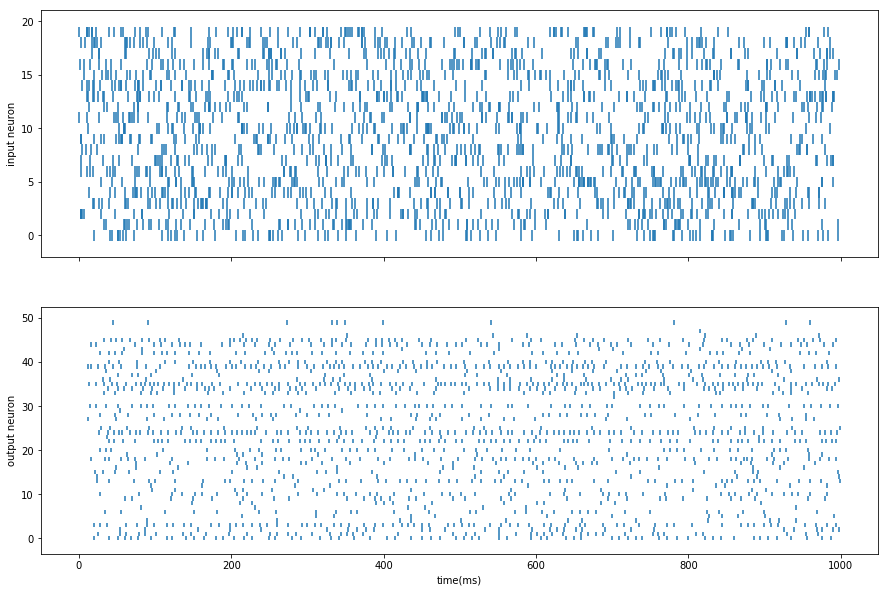

In [12]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Simulate
nest.ResetNetwork()
nest.Simulate(T)

# Visualize spiking activities of neuron populations
visualSS(in_det, out_det);

### Coincidence of Spikes

Wow, quite a bunch of spikes. Don't worry, let's count the **coincidence of spikes** between different output neurons shown above.

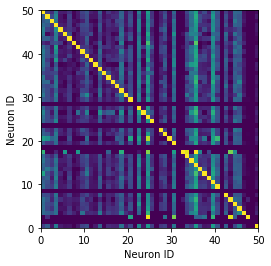

In [13]:
# Recording
eventS = nest.GetStatus(out_det, 'events')
spikes = [event['times'] for event in eventS]

# Binning
vS = np.zeros([N_ex, int(T/dt)])
kernel = np.ones(int(5/dt))
for i,spike in enumerate(spikes):
    vS[i] = spike2bin(signal=spike, template=vS[i], kernel=kernel, dt=dt)

# Counting coincidence
coM,_ = spikeCoin(spikeMat=vS, type=1)
plt.imshow(coM, extent=[0,N_ex,0,N_ex])
plt.xlabel('Neuron ID');
plt.ylabel('Neuron ID');

As shown above, some pairs of neurons have strong correlations. Correlation arises in this simple two-layer network. 
>**What is the underlying mechanism?**

In this simple case, the pair-wise correlation arises from the sharing of inputs as a natural result. To get further understanding, let's look even closer at a pair of neurons and ask this question:
>**If we consider a neuron as an input-output device, how is input correlation projected to output correlation?**

## 4. Pair-wise Correlation Transfer

> Let's systematically examine how the pair-wise correlation transfers from input to output!

### Probablistic Copy
We are gonna generate spike trains of arbitrary correlations with **probabilistic copy**. **Probabilistic copy** means, just as the words, to copy spikes from a common spike train with certain probability.

![Correlation Single Neuron](../Figures/Correlation.png)

As shown in the figure above, a *mother spike* train is copied to several *pool spike* trains with probability $b$. Then each *pool spike* train is copied to a pool of *input neurons* with probability $w$. With inputs prepared as such, each pair of pools have certain *pool correlation* and each pair of input neurons have certain *individual correlation*.

### Activating Neuron
We activate the same output neuron with each pool of input neurons and record the output activities shown as the spiking events on the right of above figure. 

>Let's KICK IT SYSTEMATICALLY!

In [14]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Model setting
N_trial = 2
N_syn = 25
N_bw = 10
nu = 5.0
seed = 0
weight = 20.0

# Save recordings
inEvents = []
outEvents = []

# Between pool copy probability
bps = np.linspace(0.1, 1.0, N_bw)
for i,bp in enumerate(bps):
    # Within pool copy probability
    wps = np.linspace(0.1, 1.0, N_bw)
    for j,wp in enumerate(wps):
        # Mother spike frequency
        f = nu/bp/wp
        
        # Initialize nest env
        nest.ResetKernel()
        nest.SetKernelStatus({'local_num_threads': 1, 'resolution': dt,
                      'overwrite_files': True, 'grng_seed': seed})

        # Multiple Interaction Process (MIP) generator
        mg = nest.Create('mip_generator')
        nest.SetStatus(mg, {'rate': f, 'p_copy': bp})
        
        # Temporary variables
        sgS = []
        pnS = []
        inS = []
        tgS = []
        outS = []
        vmS = []
        for _ in range(N_trial):
            # Pool spike trains
            sgS.append(nest.Create('spike_dilutor', N_syn))
            nest.SetStatus(sgS[-1], {'p_copy': wp})
            nest.Connect(mg, sgS[-1])

            # Input neurons
            pnS.append(nest.Create('parrot_neuron', N_syn))
            inS.append(nest.Create('spike_detector', N_syn))
            nest.Connect(sgS[-1], pnS[-1])
            nest.Connect(pnS[-1], inS[-1], 'one_to_one')

            # Output neuron
            tgS.append(nest.Create('iaf_psc_alpha'))
            outS.append(nest.Create('spike_detector'))
            vmS.append(nest.Create('voltmeter'))
            nest.SetStatus(vmS[-1], "withtime", True)

            # Connect devices and inputs
            nest.Connect(pnS[-1], tgS[-1], syn_spec={"weight": weight})
            nest.Connect(tgS[-1], outS[-1], 'one_to_one')
            nest.Connect(vmS[-1], tgS[-1])

        # Simulate
        nest.Simulate(T)
        
        # Save experiment of one (b,w) pair
        inEvent = [nest.GetStatus(inN, 'events') for inN in inS]
        outEvent = [nest.GetStatus(outN, 'events') for outN in outS]
        inEvents.append(inEvent)
        outEvents.append(outEvent)
        
# Extract spikes
inSpikes = []
outSpikes = []
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        inSpike = []
        outSpike = []
        for k in range(N_trial):
            inSpike.append([inEvent['times'] for inEvent in inEvents[idx][k]])
            outSpike.append(outEvents[idx][k][0]['times'])
        inSpikes.append(inSpike)
        outSpikes.append(outSpike)
        
# Binning spikes
binOuts = []
kernel = np.ones(int(5/dt))
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        binOut = []
        for k in range(N_trial):
            binOut.append(spike2bin(outSpikes[idx][k], np.zeros(int(T/dt)), kernel, dt))
        binOuts.append(np.array(binOut))

#### Absolute Coincidence

The **absolute coincidence** of the output activities has peak value at certain $\{b,w\}$ region. The reason is quite simple: when input correlation is too low, there are not enough spikes arrived at the same time thus cannot activate the neuron; when the input correlation is too high, there are abundant spikes arrived at the same time thus the number of possible activation is reduced. In one word, the inputs are well **exploited** with certain input correlation.

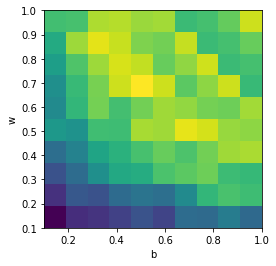

In [15]:
# Absolute coincidence
coM = np.zeros([N_bw, N_bw])
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        coV, coM[i][j]  = spikeCoin(binOuts[idx])
    
# Visualize
plt.figure()
plt.imshow(coM, extent=[0.1,1,0.1,1], origin='lower')
plt.xlabel('b');
plt.ylabel('w');

#### Normalized Coincidence

The **absolute coincidence** can be normalized with the **energy** as $c_{norm}(i,j) = \frac{coin(s_i, s_j)}{coin(s_i,s_i)}$, where the function $coin$ calculates the absolute coincidence of two sequences $s_i,s_j$. The **normalized coincidence** keep increasing as the input correlation or $\{b,w\}$ increases.

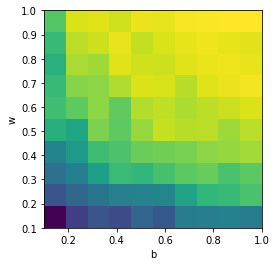

In [16]:
# Normalized coincidence
coM = np.zeros([N_bw, N_bw])
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        coV, coM[i][j]  = spikeCoin(binOuts[idx], type=1)
    
# Visualize
plt.figure()
plt.imshow(coM, extent=[0.1,1,0.1,1], origin='lower')
plt.xlabel('b');
plt.ylabel('w');

## 5. Beyond Point Neuron

Our good old IAF neuron is a point neuron meaning that all the magic happens in the **soma**. As said in the documation of NEST Simulator:

> The iaf_psc_alpha is the standard model used to check the consistency of the nest simulation kernel because it is at the same time complex enough to exhibit non-trivial dynamics and simple enough compute relevant measures analytically. 

However, the real situation is much more interesting! Fluctuations at synapses are transferred to the soma along the dendritic tree which brings lots of debates on the transfer mechanism. The soma integration is more complicated than the capacitor-like integration which induces many non-trivial phenomenons. We'll investigate them in following tutorials and see how we can simply those mechanisms to plausible models for certain purposes.